In [26]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
# from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

pd.plotting.register_matplotlib_converters()

from math import sqrt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 18, 8
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
df = pd.read_excel('E:/Demand_forecasting_assignment/tensku_forecast.xlsx',sheet_name='2528963',index_col=[0], parse_dates=[0])

In [4]:
df.columns

Index(['Sale'], dtype='object')

In [4]:
# df['year'] = pd.to_datetime(df['year'], format='%Y-%m')
# y = df.set_index('year')

In [5]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_val = df['Sale'].values
df_val = df_val.reshape(-1, 1)
df_val_scaled = scaler.fit_transform(df_val)
df["scaled_y"] = df_val_scaled

C:\Users\RONAK JAIN\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
df.head()

,Sale,scaled_y
Date,,
2017-01-01,0,0.0
2017-01-08,0,0.0
2017-01-15,0,0.0
2017-01-22,0,0.0
2017-01-29,0,0.0


In [7]:
for obs in range(1,13):
    df["T_" + str(obs)] = df.scaled_y.shift(obs)

In [8]:
df.fillna(0.00,inplace=True)
df.head(10)

,Sale,scaled_y,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10,T_11,T_12
Date,,,,,,,,,,,,,,
2017-01-01,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-08,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-15,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-22,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-29,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-05,3,0.000454,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-12,0,0.000000,0.000454,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-19,0,0.000000,0.000000,0.000454,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-26,0,0.000000,0.000000,0.000000,0.000454,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_data = df[:int(0.6*df.shape[0])]
val_data = df[int(0.6*df.shape[0]):int(0.8*df.shape[0])]
test_data = df[int(0.8*df.shape[0]):]

In [10]:
print(train_data.shape, val_data.shape, test_data.shape)

(93, 14) (31, 14) (32, 14)


In [13]:
# x_train = train_data.drop(["Sale" ,"scaled_y"], axis = 1)
y_train = train_data["scaled_y"]
x_val = val_data.drop(["Sale","scaled_y"] , axis = 1)
y_val = val_data["scaled_y"]
x_test = test_data.drop(["Sale","scaled_y"], axis = 1)
y_test = test_data["scaled_y"]

x_full = df.drop(["Sale","scaled_y"], axis = 1)
y_full = df["Sale"]

In [14]:
print(x_train.shape, val_data.shape, test_data.shape)

(93, 12) (31, 14) (32, 14)


In [27]:
"""
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_valid_scaled = scaler.fit_transform(x_val)

x_t_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))
"""


'\nfrom sklearn.preprocessing import StandardScaler,MinMaxScaler\nscaler = StandardScaler()\n\nx_train_scaled = scaler.fit_transform(x_train)\nx_test_scaled = scaler.fit_transform(x_test)\nx_valid_scaled = scaler.fit_transform(x_val)\n\nx_t_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))\nx_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))\n'

In [15]:

'''
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_valid_scaled = scaler.fit_transform(x_val)
'''

x_train = x_train.values
x_val = x_val.values
x_t_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val_reshaped = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [17]:
model_k = Sequential()
model_k.add(LSTM(100, input_shape=(1,12)))
model_k.add(Dropout(0.1))
model_k.add(Dense(1))
model_k.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
history = model_k.fit(x_t_reshaped, y_train, validation_data=(x_val_reshaped, y_val),epochs=100, batch_size=12, verbose=1)


Train on 93 samples, validate on 31 samples
Epoch 1/100
93/93 [==============================] - 2s 23ms/step - loss: 0.1485 - val_loss: 0.1744
Epoch 2/100
93/93 [==============================] - 0s 592us/step - loss: 0.0656 - val_loss: 0.0905
Epoch 3/100
93/93 [==============================] - 0s 558us/step - loss: 0.0324 - val_loss: 0.0797
Epoch 4/100
93/93 [==============================] - 0s 502us/step - loss: 0.0355 - val_loss: 0.0814
Epoch 5/100
93/93 [==============================] - 0s 544us/step - loss: 0.0336 - val_loss: 0.0767
Epoch 6/100
93/93 [==============================] - 0s 473us/step - loss: 0.0321 - val_loss: 0.0751
Epoch 7/100
93/93 [==============================] - 0s 469us/step - loss: 0.0294 - val_loss: 0.0751
Epoch 8/100
93/93 [==============================] - 0s 511us/step - loss: 0.0301 - val_loss: 0.0728
Epoch 9/100
93/93 [==============================] - 0s 528us/step - loss: 0.0295 - val_loss: 0.0712
Epoch 10/100
93/93 [===========================

Epoch 79/100
93/93 [==============================] - 0s 346us/step - loss: 0.0201 - val_loss: 0.0599
Epoch 80/100
93/93 [==============================] - 0s 338us/step - loss: 0.0205 - val_loss: 0.0601
Epoch 81/100
93/93 [==============================] - 0s 328us/step - loss: 0.0203 - val_loss: 0.0596
Epoch 82/100
93/93 [==============================] - 0s 366us/step - loss: 0.0205 - val_loss: 0.0595
Epoch 83/100
93/93 [==============================] - 0s 357us/step - loss: 0.0203 - val_loss: 0.0594
Epoch 84/100
93/93 [==============================] - 0s 429us/step - loss: 0.0192 - val_loss: 0.0595
Epoch 85/100
93/93 [==============================] - 0s 383us/step - loss: 0.0195 - val_loss: 0.0593
Epoch 86/100
93/93 [==============================] - 0s 433us/step - loss: 0.0200 - val_loss: 0.0586
Epoch 87/100
93/93 [==============================] - 0s 439us/step - loss: 0.0190 - val_loss: 0.0585
Epoch 88/100
93/93 [==============================] - 0s 350us/step - loss: 0.0195

In [19]:
x_test = x_test.values
x_te_reshaped = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

x_full_arr = x_full.values
x_full_reshaped = x_full_arr.reshape((x_full.shape[0], 1, x_full.shape[1]))

In [20]:
res_tr = model_k.predict(x_t_reshaped)
res_val = model_k.predict(x_val_reshaped)
res_test = model_k.predict(x_te_reshaped)

res_full = model_k.predict(x_full_reshaped)

In [21]:
print(res_tr.shape, res_val.shape,res_test.shape)

(93, 1) (31, 1) (32, 1)


In [22]:
y_pred_tr = scaler.inverse_transform(res_tr)
y_pred_val = scaler.inverse_transform(res_val)
y_pred_test = scaler.inverse_transform(res_test)
y_act = df["Sale"].values

y_full= scaler.inverse_transform(res_full)

In [23]:
look_back = 12

In [24]:

# shift train predictions for plotting
all_y = df["scaled_y"].values

dataset= all_y.reshape(-1, 1)
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
#print(trainPredictPlot)
trainPredictPlot[:len(y_pred_tr), :] = y_pred_tr

valPredictPlot = np.empty_like(dataset)
valPredictPlot[:, :] = np.nan
#print(trainPredictPlot)
valPredictPlot[len(y_pred_tr) : len(y_pred_tr) + len(y_pred_val), :] = y_pred_val

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#print(trainPredictPlot)
testPredictPlot[len(y_pred_tr) + len(y_pred_val):, :] = y_pred_test

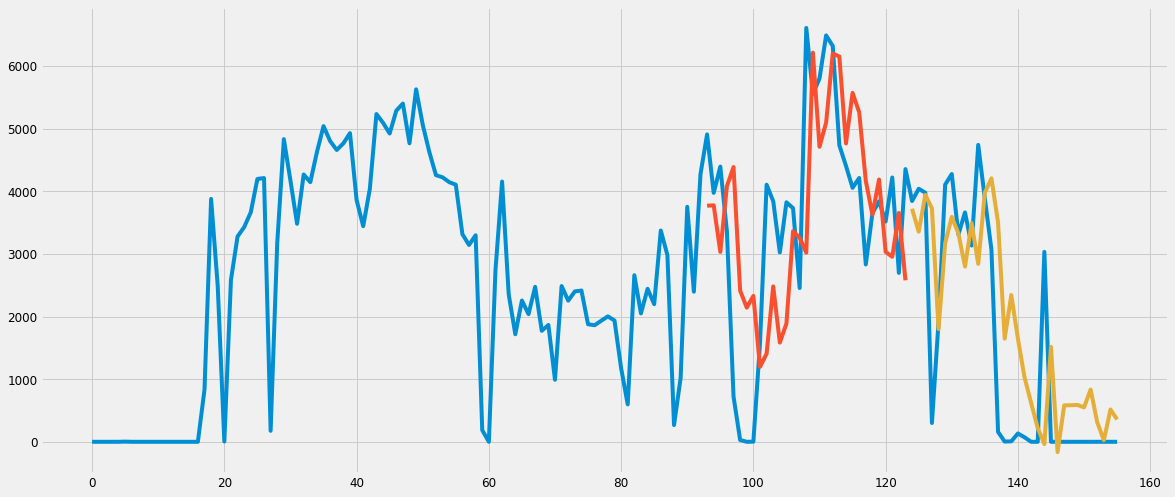

In [27]:
matplotlib.rcParams['figure.figsize'] = 18, 8
plt.plot(y_act)
plt.plot(valPredictPlot)
plt.plot(testPredictPlot)


In [28]:
#R^2

from sklearn.metrics import r2_score
print(r2_score(y_act, y_full)*100)

62.74036066645363


In [29]:
np.savetxt("LSTM_RESULT.csv", y_act)

In [30]:
print(y_act)

[   0    0    0    0    0    3    0    0    0    0    0    0    0    0
    0    0    0  831 3877 2487    4 2584 3277 3427 3664 4196 4210  175
 3175 4831 4168 3480 4267 4145 4624 5039 4800 4658 4764 4927 3859 3441
 4036 5232 5092 4921 5285 5399 4765 5626 5062 4625 4256 4222 4145 4104
 3314 3142 3297  186    0 2737 4154 2355 1717 2255 2038 2474 1772 1865
  990 2486 2253 2400 2415 1876 1861 1933 2002 1936 1175  597 2659 2049
 2442 2197 3373 2980  267 1020 3751 2396 4271 4907 3974 4393 3356  720
   29    0    2 1568 4104 3841 3023 3823 3729 2455 6606 5554 5800 6487
 6319 4733 4405 4054 4211 2831 3649 3837 3515 4219 2696 4353 3843 4039
 3976  300 1912 4105 4274 3307 3662 3133 4739 3883 3067  157    4    7
  133   72    0    0 3032    0    0    0    0    0    0    0    0    0
    0    0]


In [31]:
np.savetxt("LSTM_RESULT_my.csv", y_full)

In [32]:
print(r2_score(y_act[int(0.77*len(y_act)):] , y_full[int(0.77*len(y_full)): ])*100)

49.68265007822457


In [33]:
y_act[int(0.75*len(y_act)):]

array([2831, 3649, 3837, 3515, 4219, 2696, 4353, 3843, 4039, 3976,  300,
       1912, 4105, 4274, 3307, 3662, 3133, 4739, 3883, 3067,  157,    4,
          7,  133,   72,    0,    0, 3032,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)